# FaceAuth

#### Loading the libraries

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings("ignore")

#### Loading the dataset

In [2]:
model_name = "FaceAuth"
path = f'Dataset/real-vs-fake/'
train_path = path + 'train/'
val_path = path + 'valid/'
test_path = path + 'test/'

input_shape = (224, 224, 3)
classes = 2
target_size = (224, 224)
batch_size = 32

#### Initializing the train image generator

In [3]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',  
)

Found 100000 images belonging to 2 classes.


#### Initializing the validation image generator

In [4]:
val_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
)

Found 20000 images belonging to 2 classes.


#### Initializing the test image generator

In [5]:
test_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
)

Found 20000 images belonging to 2 classes.


#### Initializing the model

In [6]:
base_model = ResNet50(
    include_top=False,
    pooling='av',
    weights='imagenet',
    input_shape=(input_shape)
)
for layer in base_model.layers:
    layer.trainable = False

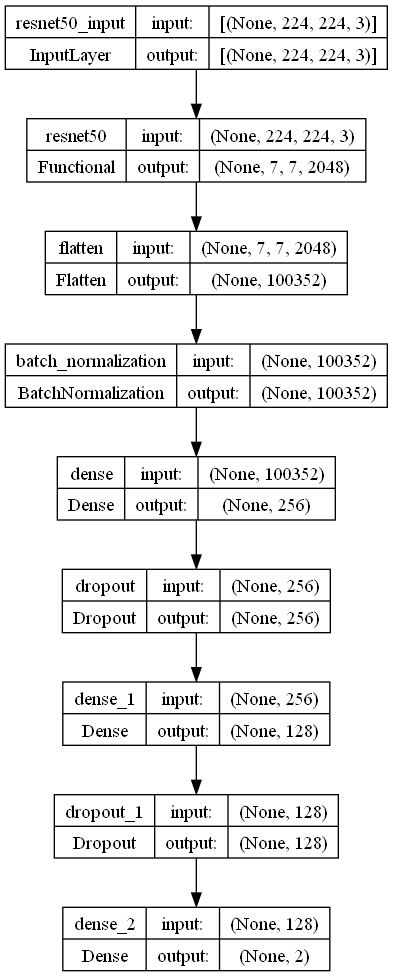

In [7]:
model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(classes, activation='sigmoid')
])
plot_model(model, to_file=f"{model_name}_architecture.png", show_shapes=True, show_layer_names=True)

#### Initializing the optimizer

In [8]:
optimizer = tf.keras.optimizers.Adam()

#### Compiling the model

In [9]:
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
checkpoint = ModelCheckpoint(
    filepath=f'{model_name}.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
earlystop = EarlyStopping(
    patience=10,
    verbose=1
)

#### Training the model

In [11]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[checkpoint, earlystop],
    verbose=1
)

Epoch 1/15
3125/3125 [==============================] - ETA: 0s - loss: 0.7705 - accuracy: 0.7201
Epoch 1: val_loss improved from inf to 0.39458, saving model to FaceAuth.h5
3125/3125 [==============================] - 1087s 346ms/step - loss: 0.7705 - accuracy: 0.7201 - val_loss: 0.3946 - val_accuracy: 0.8205
Epoch 2/15
3125/3125 [==============================] - ETA: 0s - loss: 0.4660 - accuracy: 0.7934
Epoch 2: val_loss improved from 0.39458 to 0.35641, saving model to FaceAuth.h5
3125/3125 [==============================] - 616s 197ms/step - loss: 0.4660 - accuracy: 0.7934 - val_loss: 0.3564 - val_accuracy: 0.8523
Epoch 3/15
3125/3125 [==============================] - ETA: 0s - loss: 0.4403 - accuracy: 0.8071
Epoch 3: val_loss improved from 0.35641 to 0.33026, saving model to FaceAuth.h5
3125/3125 [==============================] - 634s 203ms/step - loss: 0.4403 - accuracy: 0.8071 - val_loss: 0.3303 - val_accuracy: 0.8562
Epoch 4/15
3125/3125 [==============================] - ET

#### Evaluating the model using the test images

In [12]:
result = model.evaluate(test_generator)

625/625 [==============================] - 46s 73ms/step - loss: 0.2336 - accuracy: 0.9169


#### Plotting the accuracy and loss

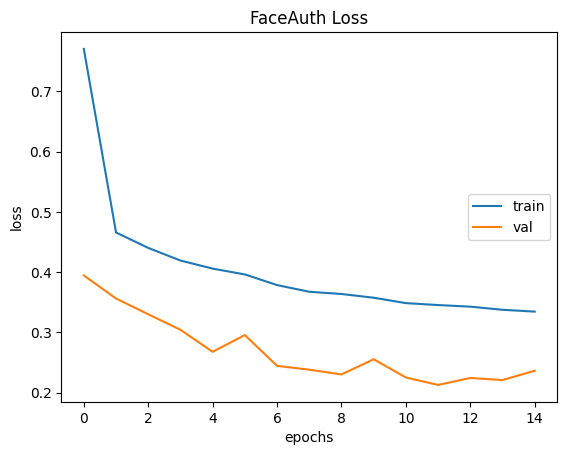

In [13]:
metrics = ["accuracy", "loss"]

for metric in metrics:
    plt.clf()
    plt.plot(history.history[metric], label='train')
    plt.plot(history.history[f'val_{metric}'], label='val')
    plt.legend(loc="right")
    plt.xlabel('epochs')
    plt.ylabel(metric)
    plt.title(f"{model_name} {metric.capitalize()}")
    plt.savefig(f'Images/{model_name}_{metric}.png')